In [1]:
# IMPORTING NECESSARY PACKAGES
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.tree import export_graphviz

# Specify the URL of the dataset
url = "https://raw.githubusercontent.com/AAI-500-Team/aai_500_dataset/main/heart_2022_no_nans.csv"

# Use pandas to read the CSV file from the URL into a DataFrame
df = pd.read_csv(url)

## Introduction

First, we're going to understand the given dataset.

In [2]:
display(df)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,Virgin Islands,Male,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,No,...,1.78,102.06,32.28,Yes,No,No,No,"Yes, received tetanus shot but not sure what type",No,No
246018,Virgin Islands,Female,Fair,0.0,7.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.93,90.72,24.34,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
246019,Virgin Islands,Male,Good,0.0,15.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,No,...,1.68,83.91,29.86,Yes,Yes,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Yes
246020,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No


In [3]:
# Use the describe method to find descriptive statistics (including the 5-summary stats)
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000
mean,4.119026,4.167140,7.021331,1.705150,83.615179,28.668136
std,8.405844,8.102687,1.440681,0.106654,21.323156,6.513973
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


###Conclusion:

The dataset has **40** columns, with numerical and categorical data. Most of the columns are categorical, with **5** numerical columns.

In [4]:
rows, columns = df.shape
print(f"Number of rows: {rows}, Number of columns: {columns}")

Number of rows: 246022, Number of columns: 40


## Data Cleaning / Preparation

Let's inspect any missing, incomplete data.

In [5]:
print(f"Number of duplicates: {df.duplicated().sum()}")
print(f"Number of missing values: {df.isnull().sum().sum()}")

Number of duplicates: 9
Number of missing values: 0


There is no missing values, but. there are duplicates. Let's drop them.
We're also going to drop BMI, since it is a function of height and weight, and there is multicollinearity.
Lastly, we're going to drop the features that are relevant to our research question.

In [6]:
# Drop duplicated
df.drop_duplicates(inplace=True)

# Drop Unrelated variables and BMI for multicollinearity with Height and Weight
df = df.drop(columns=['State', 'LastCheckupTime','BMI'])

In [7]:
# Create lists of numerical variables, categorical variables and target variable for future use
numerical_vars = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']
categorical_includes_taget = ['Sex', 'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos','HadHeartAttack']

categorical_vars = ['Sex', 'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos']
target = 'HadHeartAttack'

print(f"Numerical variables: {numerical_vars}")
print(f"Catergorical variables: {categorical_vars}")
print(f"Target variable: {target}")

Numerical variables: ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']
Catergorical variables: ['Sex', 'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']
Target variable: HadHeartAttack


## Exploratory Data Analysis

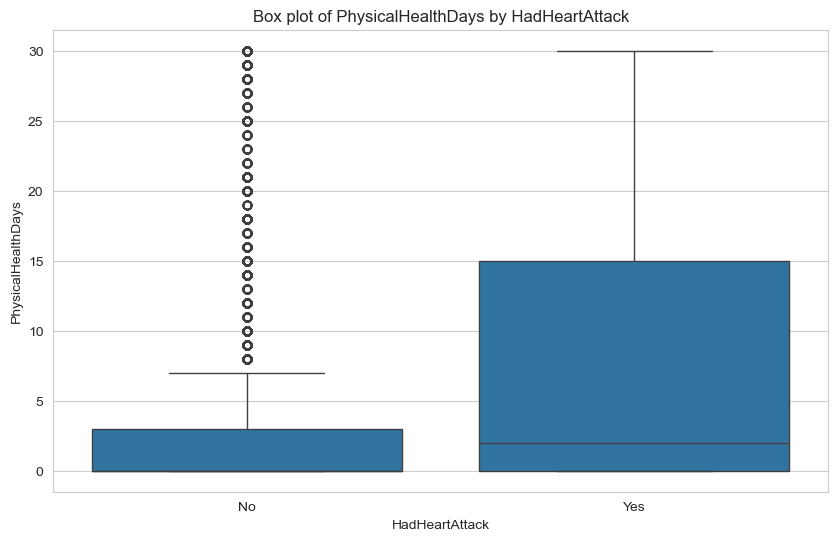

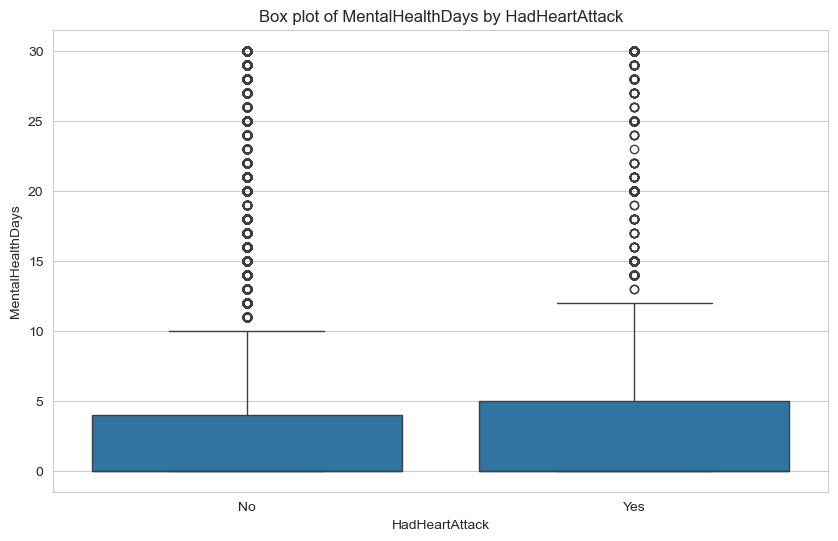

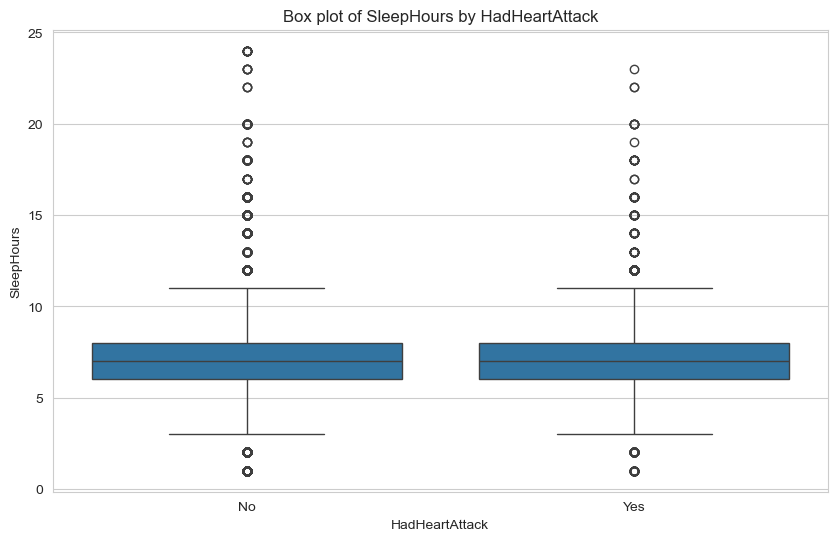

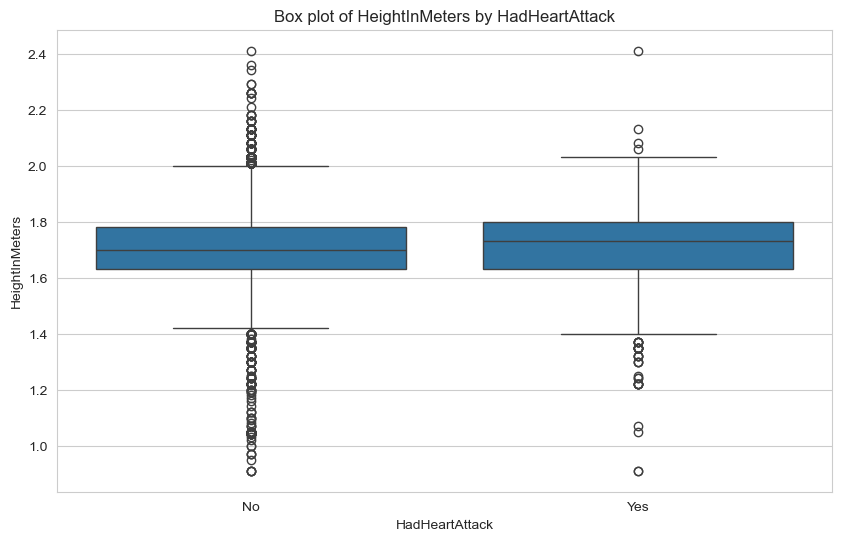

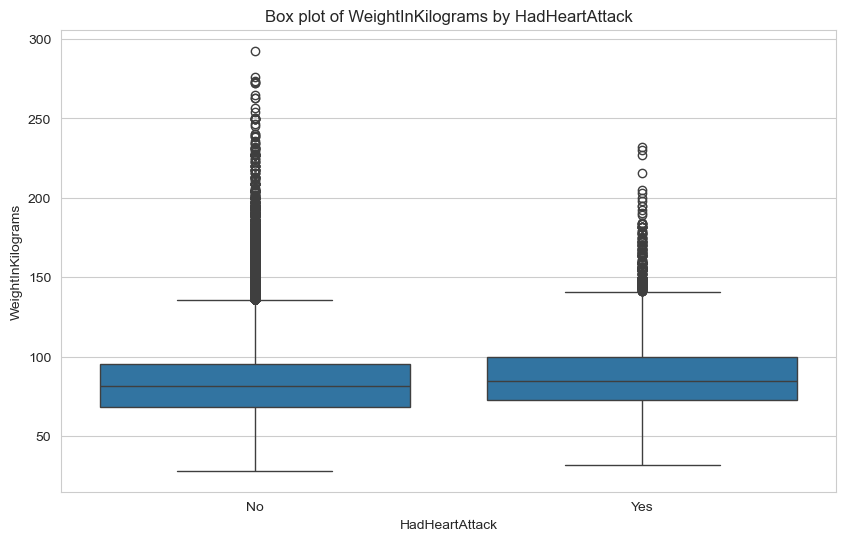

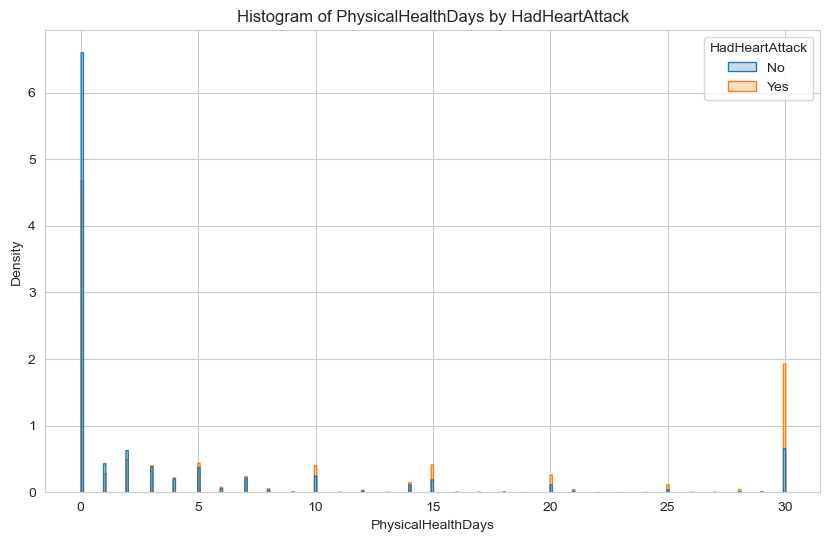

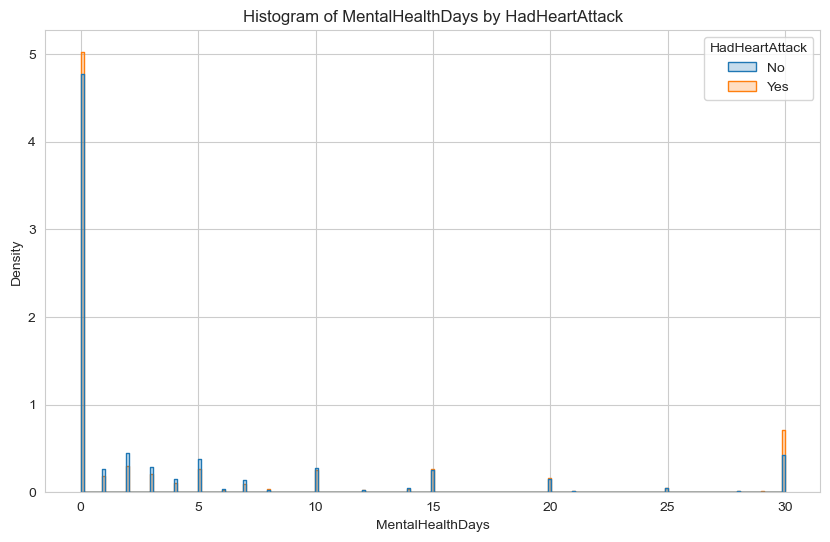

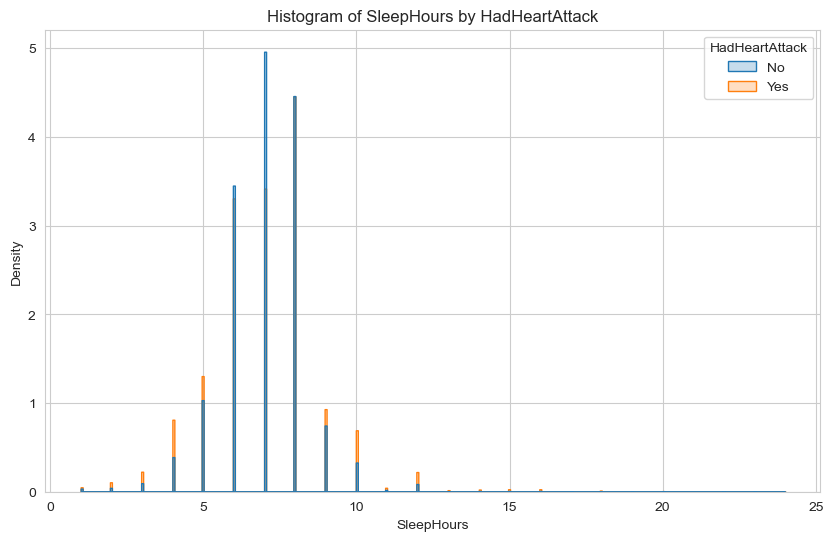

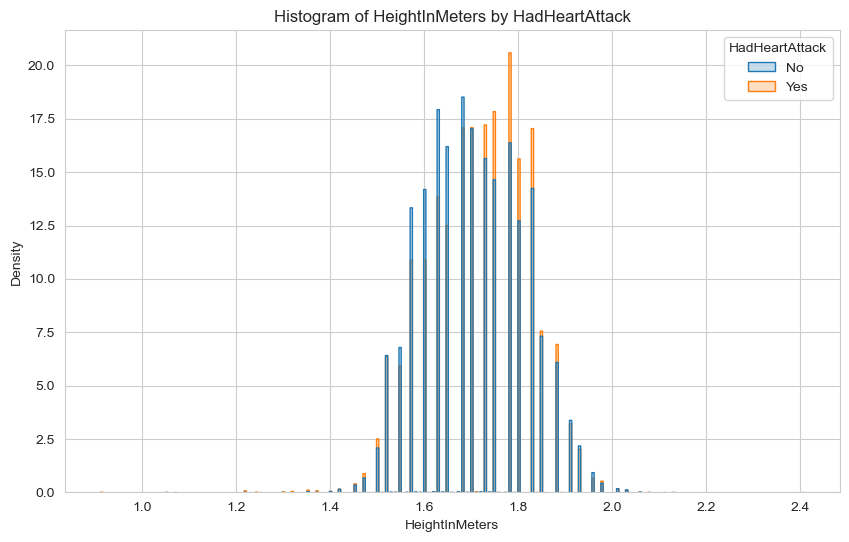

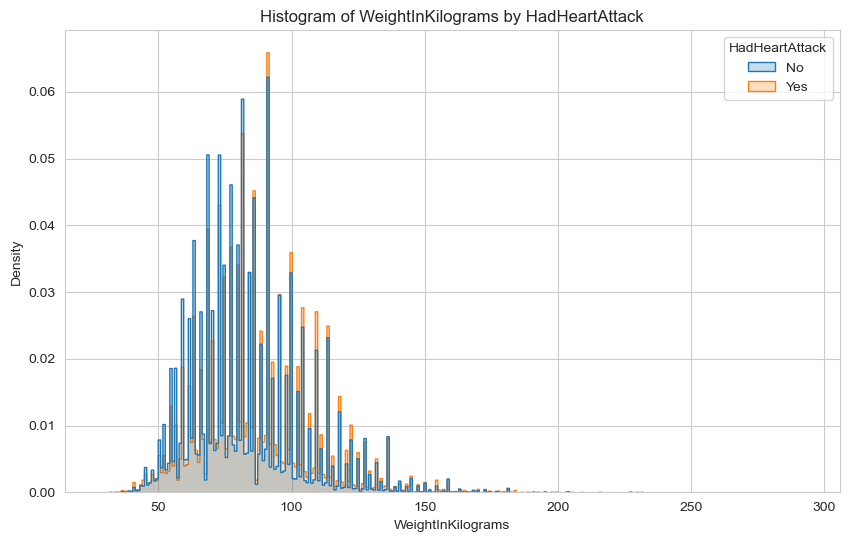

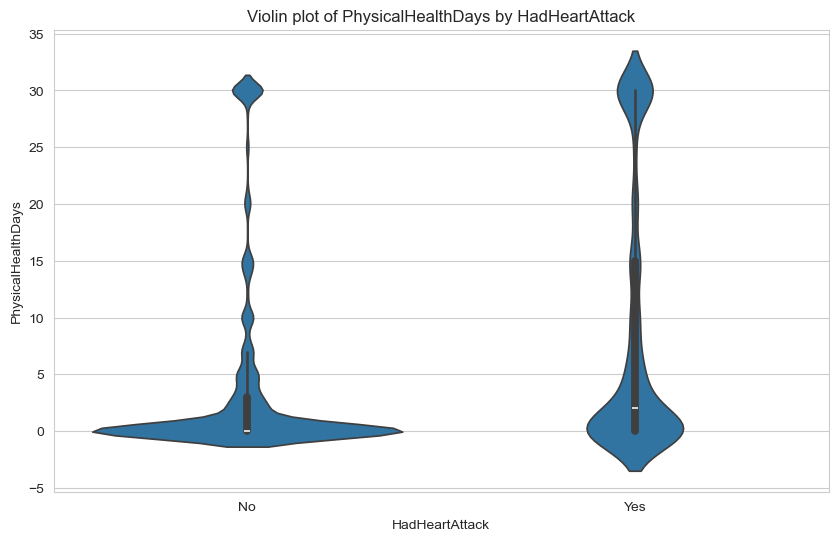

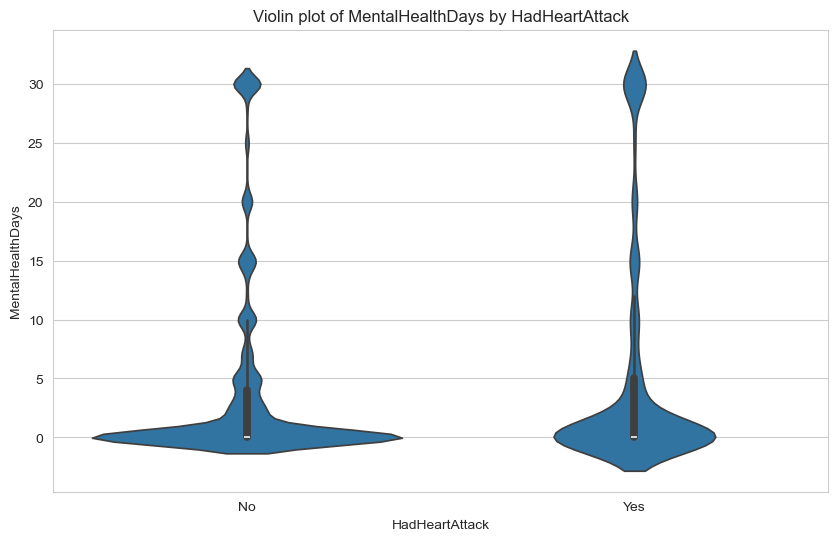

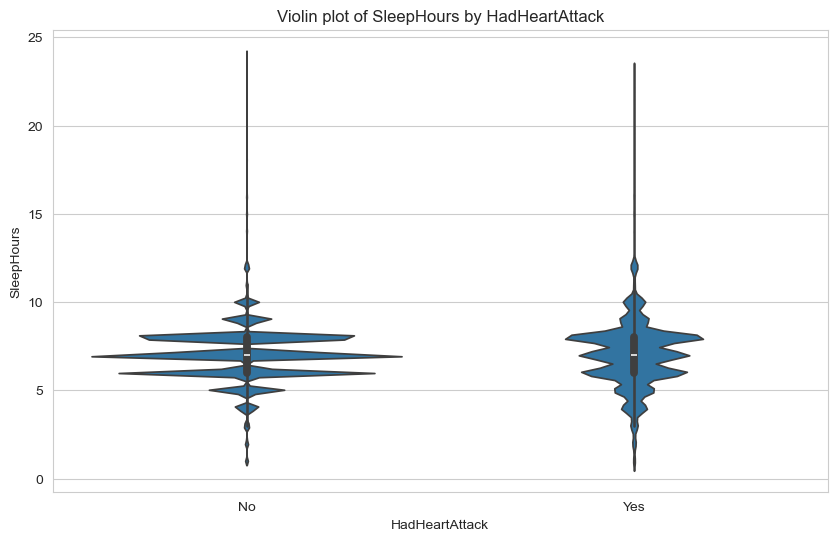

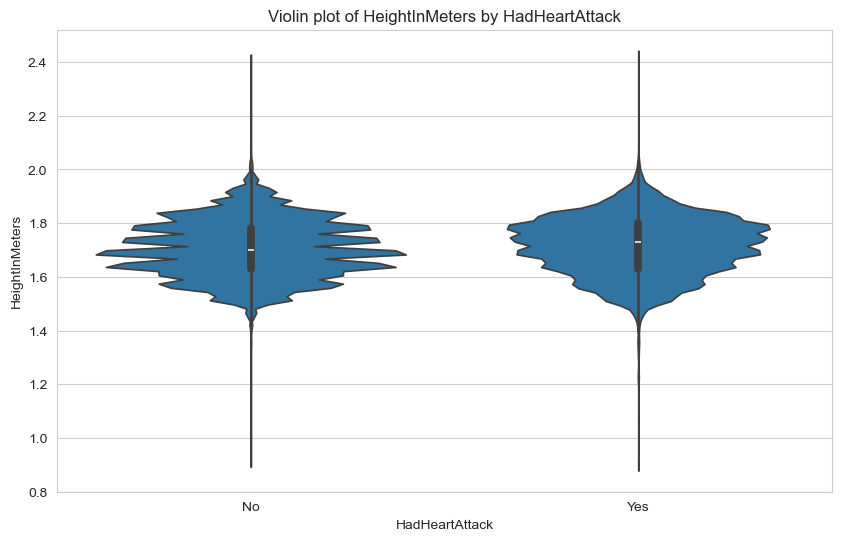

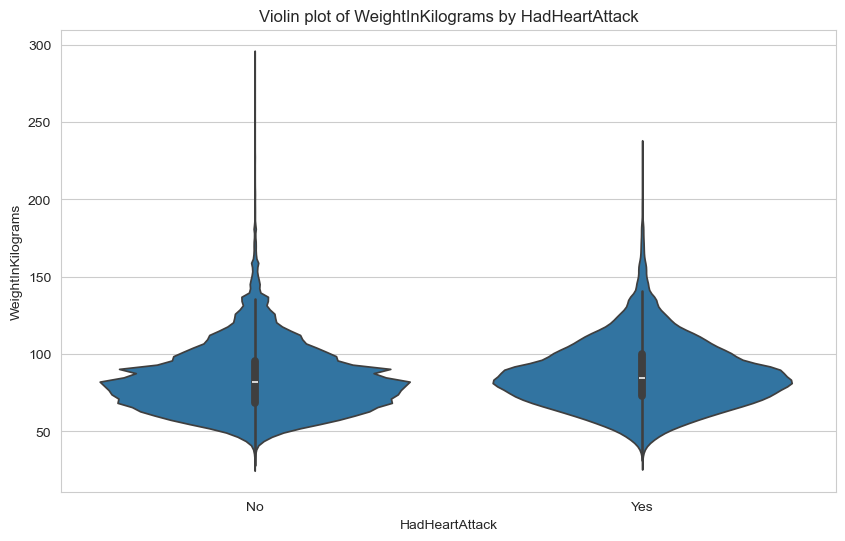

In [8]:
# Create box plots, histograms, and violin plots for numerical data
sns.set_style("whitegrid")
# Box Plots
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target, y=var, data=df)
    plt.title(f"Box plot of {var} by {target}")
    plt.show()
# Histograms
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x=var, hue=target, element="step", stat="density", common_norm=False)
    plt.title(f"Histogram of {var} by {target}")
    plt.show()
# Violin Plots
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=target, y=var, data=df)
    plt.title(f"Violin plot of {var} by {target}")
    plt.show()

In [9]:
# Dataframe to store result of Chi2 test
results_df_cat = pd.DataFrame(columns=['Feature', 'Chi2', 'P-Value'])

# Copy to keep the original dataframe
cat_df = df.copy()
cat_df["HadHeartAttack"] = cat_df["HadHeartAttack"].astype('category')

# For each categorical ver perform Chi2 test
# Print results, create bar plot
for var in categorical_vars:
  cat_df[var] = cat_df[var].astype('category')
  contingency_table = pd.crosstab(cat_df[var], cat_df["HadHeartAttack"])
  chi2, p, _, _ = chi2_contingency(contingency_table)
  print(contingency_table)
  print(f"Chi-Squared Test for {var} and {target}")
  print(f"Chi2 value = {chi2}, p-value = {p}\n")
  # Add the results to the DataFrame
  new_row = {'Feature': var, 'Chi2': chi2, 'P-Value': p}
  results_df_cat = pd.concat([results_df_cat, pd.DataFrame(new_row, index=[0])], ignore_index=True)
  # Bar Plots
  plt.figure(figsize=(15, 8))
  sns.countplot(data=df, x=var, hue=target)
  plt.title(f"Distribution of {var} by {target}")
  plt.show()


HadHeartAttack      No   Yes
Sex                         
Female          122874  4932
Male            109704  8503
Chi-Squared Test for Sex and HadHeartAttack
Chi2 value = 1321.7634745274654, p-value = 2.1073833823909984e-289



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Perform t-tests for numerical data
results_df_nums = pd.DataFrame(columns=['Feature', 'Statistic', 'P-Value'])

for var in numerical_vars:
  # Statistical Test (e.g., t-test) for significance
  for category in df[target].unique():
    group1 = df[df[target] == category][var]
    group2 = df[df[target] != category][var]

  stat, p = ttest_ind(group1, group2)

  # Add the results to the DataFrame
  new_row = {'Feature': var, 'Statistic': stat, 'P-Value': p}
  results_df_nums = pd.concat([results_df_nums, pd.DataFrame(new_row, index=[0])], ignore_index=True)


In [ ]:
# Sort the DataFrame by p-values in ascending order and then by chi2 values in descending order
results_df_cat = results_df_cat.sort_values(by=['P-Value', 'Chi2'], ascending=[True, False])

# Display the sorted DataFrame
display(results_df_cat)

,Feature,Chi2,P-Value
4,HadAngina,48906.220749,0.000000e+00
1,GeneralHealth,9893.539444,0.000000e+00
23,AgeCategory,7925.704390,0.000000e+00
5,HadStroke,7716.361887,0.000000e+00
3,RemovedTeeth,6996.544849,0.000000e+00
21,ChestScan,6922.660387,0.000000e+00
16,DifficultyWalking,6286.838781,0.000000e+00
12,HadDiabetes,5345.991257,0.000000e+00
8,HadCOPD,4363.963228,0.000000e+00
27,PneumoVaxEver,3539.443494,0.000000e+00


In [ ]:
# Sort the DataFrame by p-values in ascending order
results_df_nums = results_df_nums.sort_values(by='P-Value', ascending=True)

# Display the sorted DataFrame
display(results_df_nums)

,Feature,Statistic,P-Value
0,PhysicalHealthDays,66.773602,0.000000e+00
4,WeightInKilograms,19.076335,4.546370e-81
1,MentalHealthDays,12.844421,9.506448e-38
3,HeightInMeters,11.440249,2.678179e-30
2,SleepHours,1.802562,7.145820e-02


### Null Hypothesis Testing

We're intersted to test the following $null$ hypothesis:

$H_0$: General health and Smoker status don't have effect on the possibility of a heart attack

$H_A$: General health and Smoker have effect on the possibility of a heart attack

In [ ]:
hypothesis_df = results_df_cat[results_df_cat['Feature'].isin(['GeneralHealth', 'SmokerStatus'])]

# Define the significance level (alpha)
alpha = 0.05  # You can choose a different alpha value if needed

# Verify the null hypothesis for each feature
for index, row in hypothesis_df.iterrows():
    feature = row['Feature']
    chi2 = row['Chi2']
    p_value = row['P-Value']

    print(f"Feature: {feature}")
    print(f"Chi-Squared Value: {chi2}")
    print(f"P-Value: {p_value}")

    if p_value < alpha:
        print("Reject the null hypothesis (𝐻0)")
        print(f"{feature} has an effect on the possibility of a heart attack.")
    else:
        print("Fail to reject the null hypothesis (𝐻0)")
        print(f"{feature} does not have an effect on the possibility of a heart attack.")

    print("\n")

Feature: GeneralHealth
Chi-Squared Value: 9893.539444125969
P-Value: 0.0
Reject the null hypothesis (𝐻0)
GeneralHealth has an effect on the possibility of a heart attack.


Feature: SmokerStatus
Chi-Squared Value: 2241.293874288016
P-Value: 0.0
Reject the null hypothesis (𝐻0)
SmokerStatus has an effect on the possibility of a heart attack.




### Conclusion

* We have complted chi square test and we able to reject the $null$ hypothesis.


## Model Selection



In [ ]:
# TESTING FOR MULTICOLLINEARITY
# Add a constant term to the predictor variables
X = add_constant(df[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']])

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             Variable         VIF
0               const  304.683975
1  PhysicalHealthDays    1.115540
2    MentalHealthDays    1.123823
3          SleepHours    1.019942
4      HeightInMeters    1.306575
5   WeightInKilograms    1.311968


In [ ]:
# HERE WE ADD DUMMIES TO THE CATEGORICAL VARIABLES
heart_df = pd.get_dummies(df, columns=categorical_includes_taget, drop_first=True, dtype='int32')
heart_df.head(5)

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,Sex_Male,GeneralHealth_Fair,GeneralHealth_Good,GeneralHealth_Poor,GeneralHealth_Very good,...,HIVTesting_Yes,FluVaxLast12_Yes,PneumoVaxEver_Yes,"TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap",HighRiskLastYear_Yes,CovidPos_Tested positive using home test without a health professional,CovidPos_Yes,HadHeartAttack_Yes
0,4.0,0.0,9.0,1.60,71.67,0,0,0,0,1,...,0,1,1,1,0,0,0,0,0,0
1,0.0,0.0,6.0,1.78,95.25,1,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
2,0.0,0.0,8.0,1.85,108.86,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,5.0,0.0,9.0,1.70,90.72,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
4,3.0,15.0,5.0,1.55,79.38,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0


In [ ]:
# REMOVE OUR DEPENDENT VARIABLE
target = 'HadHeartAttack_Yes'
X = heart_df.drop(target, axis=1)
y = heart_df[target]

Since, the dataset description suggested unbalanced data, we are going to perform model training:

* On the oriignal data
* Training data with oversamling with SMOTE
* Traning data with undersampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GENERATING THE OVERSAMPLE:
smote = SMOTE(random_state=42)
X_ovsampled, y_ovsampled = smote.fit_resample(X_train, y_train)

# GENERATING THE UNDERSAMPLE:
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

In [ ]:
# LOGISTIC REGRESSION
def train_and_evaluate_logit(X_train, X_test, y_train, y_test, random_state=42):
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()

    X_train_ = sm.add_constant(X_train_)
    X_test_ = sm.add_constant(X_test_)
    result = sm.Logit(y_train, X_train_).fit()

    y_pred = result.predict(X_test_)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return (result, report_df)

In [ ]:
# DECISION TREE MODEL
def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test, random_state=42):
    # Create and fit a DecisionTreeClassifier
    classifier = DecisionTreeClassifier(random_state=random_state)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return (classifier, report_df)

In [ ]:
# RESULTS FOR LOGISTIC REGRESSION WITH ORIGINAL DATA
result_log, report_df_log = train_and_evaluate_logit(X_train, X_test, y_train, y_test)
display(report_df_log)

Optimization terminated successfully.
         Current function value: 0.145333
         Iterations 10


,precision,recall,f1-score,support
0,0.958957,0.988616,0.973561,46558.00000
1,0.560166,0.255198,0.350649,2645.00000
accuracy,0.949190,0.949190,0.949190,0.94919
macro avg,0.759561,0.621907,0.662105,49203.00000
weighted avg,0.937519,0.949190,0.940075,49203.00000


In [ ]:
# RESULTS FOR LOGISTIC REGRESSION WITH OVERSAMPLE WITH SMOTE
result_log_ov, report_df_log_ov = train_and_evaluate_logit(X_ovsampled, X_test, y_ovsampled, y_test)
display(report_df_log_ov)

Optimization terminated successfully.
         Current function value: 0.210821
         Iterations 9


,precision,recall,f1-score,support
0,0.962746,0.926414,0.944231,46558.000000
1,0.221717,0.368998,0.276997,2645.000000
accuracy,0.896449,0.896449,0.896449,0.896449
macro avg,0.592232,0.647706,0.610614,49203.000000
weighted avg,0.922911,0.896449,0.908363,49203.000000


In [ ]:
# RESULTS FOR LOGISTIC REGRESSION WITH UNDERSAMPLE
result_log_un, report_df_log_un = train_and_evaluate_logit(X_undersampled, X_test, y_undersampled, y_test)
display(report_df_log_un)

Optimization terminated successfully.
         Current function value: 0.421748
         Iterations 7


,precision,recall,f1-score,support
0,0.984156,0.836505,0.904343,46558.000000
1,0.209553,0.762949,0.328798,2645.000000
accuracy,0.832551,0.832551,0.832551,0.832551
macro avg,0.596855,0.799727,0.616571,49203.000000
weighted avg,0.942516,0.832551,0.873404,49203.000000


In [ ]:
# RESULTS FOR DECISION TREE (ORIGINAL DATA)
result_tree, report_df_tree = train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test)
display(report_df_tree)

,precision,recall,f1-score,support
0,0.959465,0.949697,0.954556,46558.000000
1,0.249118,0.293762,0.269604,2645.000000
accuracy,0.914436,0.914436,0.914436,0.914436
macro avg,0.604292,0.621729,0.612080,49203.000000
weighted avg,0.921279,0.914436,0.917735,49203.000000


In [ ]:
# RESULTS FOR DECISION TREE WITH OVERSAMPLE
result_tree_ov, report_df_tree_ov = train_and_evaluate_decision_tree(X_ovsampled, X_test, y_ovsampled, y_test)
display(report_df_tree_ov)

,precision,recall,f1-score,support
0,0.959798,0.922505,0.940782,46558.000000
1,0.189942,0.319849,0.238343,2645.000000
accuracy,0.890108,0.890108,0.890108,0.890108
macro avg,0.574870,0.621177,0.589563,49203.000000
weighted avg,0.918413,0.890108,0.903021,49203.000000


In [ ]:
# RESULTS FOR DECISION TREE WITH UNDERSAMPLE
result_tree_un, report_df_tree_un = train_and_evaluate_decision_tree(X_undersampled, X_test, y_undersampled, y_test)
display(report_df_tree_un)

,precision,recall,f1-score,support
0,0.978397,0.721788,0.830727,46558.000000
1,0.128096,0.719471,0.217473,2645.000000
accuracy,0.721663,0.721663,0.721663,0.721663
macro avg,0.553247,0.720629,0.524100,49203.000000
weighted avg,0.932687,0.721663,0.797761,49203.000000


### Conclusion

* Neither oversampling, nor undersampling produced desired results improving precision, i.e. the accuracy of the positive predictions made by the model
* Compared by the accuracy of the model on the entire dataset, and by mimizing the poor precision performance, **Logistic Regression** trained on the original data performed the best.
* Selected model has recall for **0** class of $\approx 98\%$, meaning low probability of false negatives, which is very important for the health data.

## Model Analysis

In [ ]:
result_log_sum = result_log.summary()

In [ ]:
result_log_sum_df = pd.DataFrame(result_log_sum.tables[1].data[1:], columns=result_log_sum.tables[1].data[0])
result_log_sum_sorted = result_log_sum_df.sort_values(by="P>|z|", ascending=True)
display(result_log_sum_sorted)

,,coef,std err,z,P>|z|,[0.025,0.975]
0,const,-5.6427,0.321,-17.585,0.000,-6.272,-5.014
63,CovidPos_Tested positive using home test witho...,-0.3420,0.084,-4.068,0.000,-0.507,-0.177
33,SmokerStatus_Former smoker,-0.1972,0.040,-4.924,0.000,-0.276,-0.119
34,SmokerStatus_Never smoked,-0.4333,0.042,-10.428,0.000,-0.515,-0.352
57,FluVaxLast12_Yes,-0.1404,0.026,-5.370,0.000,-0.192,-0.089
...,...,...,...,...,...,...,...
37,ECigaretteUsage_Use them some days,0.0449,0.085,0.528,0.598,-0.122,0.212
60,"TetanusLast10Tdap_Yes, received tetanus shot b...",-0.0143,0.029,-0.502,0.616,-0.070,0.042
17,HadAsthma_Yes,0.0138,0.033,0.422,0.673,-0.050,0.078
36,ECigaretteUsage_Use them every day,-0.0210,0.103,-0.204,0.838,-0.222,0.180


In [ ]:
result_log_sum_df_feature_of_interest = result_log_sum_sorted[result_log_sum_sorted[''].isin(['SmokerStatus_Former smoker', 'SmokerStatus_Never smoked', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'GeneralHealth_Good', 'GeneralHealth_Very good', 'SmokerStatus_Current smoker - now smokes some days'])]

In [ ]:
display(result_log_sum_df_feature_of_interest)

,,coef,std err,z,P>|z|,[0.025,0.975]
33,SmokerStatus_Former smoker,-0.1972,0.040,-4.924,0.000,-0.276,-0.119
34,SmokerStatus_Never smoked,-0.4333,0.042,-10.428,0.000,-0.515,-0.352
7,GeneralHealth_Fair,0.8915,0.058,15.372,0.000,0.778,1.005
8,GeneralHealth_Good,0.6649,0.053,12.550,0.000,0.561,0.769
9,GeneralHealth_Poor,1.0154,0.071,14.360,0.000,0.877,1.154
10,GeneralHealth_Very good,0.3281,0.054,6.054,0.000,0.222,0.434
32,SmokerStatus_Current smoker - now smokes some ...,-0.0045,0.067,-0.068,0.946,-0.135,0.126


###Conclusion

* Smoker status related features have the folloiwing results:
  * `SmokerStatus_Former smoker` has coefficient `-0.1972`,`SmokerStatus_Never smoked` has coefficient `-0.4333`, suggesting negative diraction of the effect on the probability of the a heart attack. In other words, quiting smoking is associated with reduce probability of having a heart attack.
  * `SmokerStatus_Current smoker - now smokes some days` has a small negative coefficient of `-0.0045`, however the $p-value$ for this feature indicates, that the effect is not statistically significant.  
  * All features for `GeneralHealth` have $p-values$ indicating that the effect is statistically significant
  * `GeneralHealth_Poor` has the highest magnitude of the coefficient, suggesting an increase in the corresponding independent variable is associated with an increased probability a heart attack